In [309]:
"""Import libs"""
import os, sys, logging, json, yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict
from pathlib import Path
from dotenv import load_dotenv

In [310]:
#load config, loggers and set paths
load_dotenv()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

base_dir = Path(os.getcwd()).parent
config_file_path = os.getenv("CONFIG_YAML_PATH", "config.yaml")
config_file = base_dir / config_file_path

if not os.path.exists(config_file):
    logger.error(f"Configuration file not found: {config_file}")
    raise FileNotFoundError(f"Configuration file not found: {config_file}")

try:
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
except yaml.YAMLError as e:
    logger.error(f"Error parsing YAML configuration file: {e}")
    raise

logger.info(f"Configuration loaded from {config_file}: {config}")

attrition_data_path = base_dir / config['data_paths']['attrition_data']

logger.info(f"Attrition data path set to: {attrition_data_path}")

2025-12-01 22:29:37,889 - INFO - Configuration loaded from c:\Users\rahul\OneDrive\Desktop\GenAI\Bain_Case_Study\config.yaml: {'rag': {'chunk_size': 500, 'chunk_overlap': 50, 'retrieval_k': 10, 'reranker_top_k': 5, 'semantic_weight': 0.8, 'bm25_weight': 0.2, 'reranker_model': 'BAAI/bge-reranker-base'}, 'generation': {'temperature': 0.3, 'max_tokens': 500, 'top_p': 0.9}, 'paths': {'supporting_docs_folder': 'supporting_docs', 'processed_docs_folder': 'processed_docs', 'chroma_db_folder': 'chroma_db', 'data_folder': 'data'}, 'logging': {'level': 'INFO', 'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'}, 'data_paths': {'attrition_data': 'data/employee_attrition.csv'}}
2025-12-01 22:29:37,891 - INFO - Attrition data path set to: c:\Users\rahul\OneDrive\Desktop\GenAI\Bain_Case_Study\data\employee_attrition.csv


In [311]:
# Load the dataset, clean in case of missing values, and do initial analysis
df = pd.read_csv(attrition_data_path)
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\nColumns:", list(df.columns))
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing Values:")
print(df.isnull().sum())

"""Inital analysis of Attrition Column"""
print("\nAttrition Value Counts:")
print(df['Attrition'].value_counts())
print(f"Attrition Rate: {(df['Attrition'] == 'Yes').mean()*100:.2f}%")

Rows: 10000, Columns: 17

Columns: ['EmployeeID', 'Age', 'Gender', 'Department', 'JobRole', 'EducationLevel', 'PerformanceRating', 'JobSatisfaction', 'EnvironmentSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'TrainingTimesLastYear', 'OverTime', 'MonthlyIncome', 'DistanceFromHome', 'Attrition']

First 5 rows:
   EmployeeID  Age  Gender Department    JobRole  EducationLevel  \
0        2001   57  Female      Sales  Executive               5   
1        2002   24    Male         IT    Manager               2   
2        2003   25    Male         IT  Executive               3   
3        2004   52    Male        R&D   Engineer               5   
4        2005   23  Female         HR  Executive               3   

   PerformanceRating  JobSatisfaction  EnvironmentSatisfaction  \
0                  4                3                        1   
1                  4                2                        2   
2                  2                2                  

In [312]:
# Converting columns with continous/wide range values to categorical for better analysis

# Tenure groups in 5-year intervals
df["TenureGroup"] = pd.cut(
    df["YearsAtCompany"],
    bins=[0, 5, 10, 15, 20, 40],
    labels=["0–5 yrs", "5–10 yrs", "10–15 yrs", "15–20 yrs", "20+ yrs"],
    include_lowest=True
)

# Performance Rating groups
df["PerformanceGroup"] = df["PerformanceRating"].map({
    1: "Bad (1-2)",
    2: "Bad (1-2)",
    3: "Average (3)",
    4: "Good (4-5)",
    5: "Good (4-5)"
})

# Job satisfaction groups
df["JobSatisfactionGroup"] = df["JobSatisfaction"].map({
    1: "Low (1-2)",
    2: "Low (1-2)",
    3: "OK (3)",
    4: "High (4-5)",
    5: "High (4-5)"
})


# Job satisfaction groups
df["JobSatisfactionGroup"] = df["JobSatisfaction"].map({
    1: "Low (1-2)",
    2: "Low (1-2)",
    3: "OK (3)",
    4: "High (4-5)",
    5: "High (4-5)"
})

# WorkLifeBalance groups
df["WorkLifeBalanceGroup"] = df["WorkLifeBalance"].map({
    1: "Bad (1-2)",
    2: "Bad (1-2)",
    3: "Average (3)",
    4: "Good (4-5)",
    5: "Good (4-5)"
})


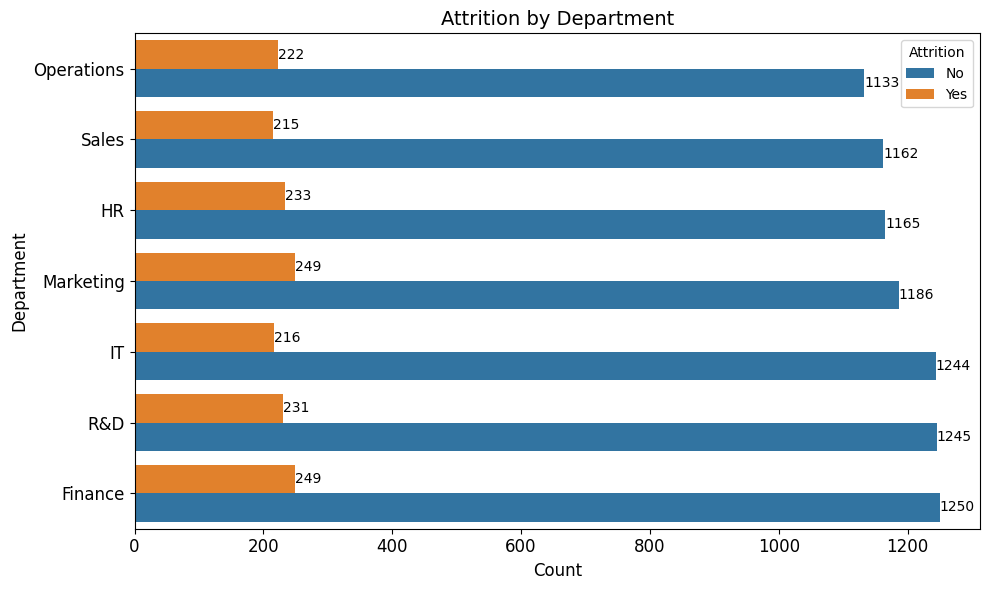

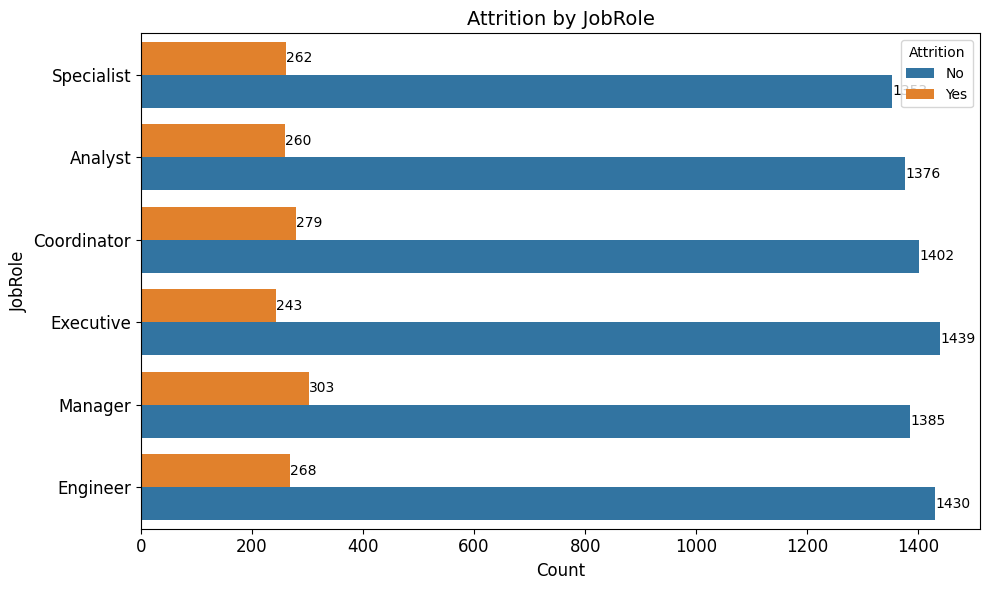

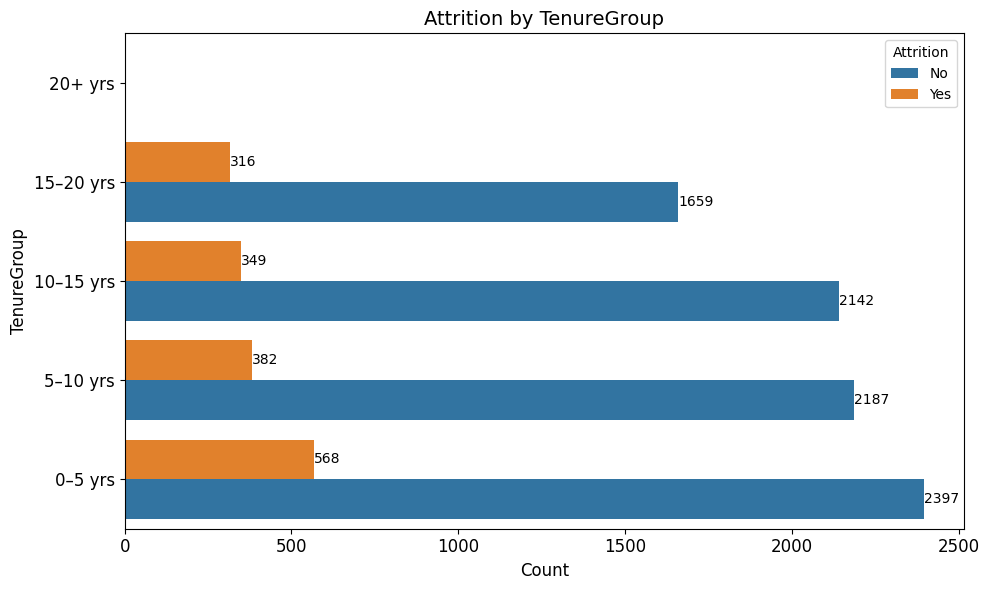

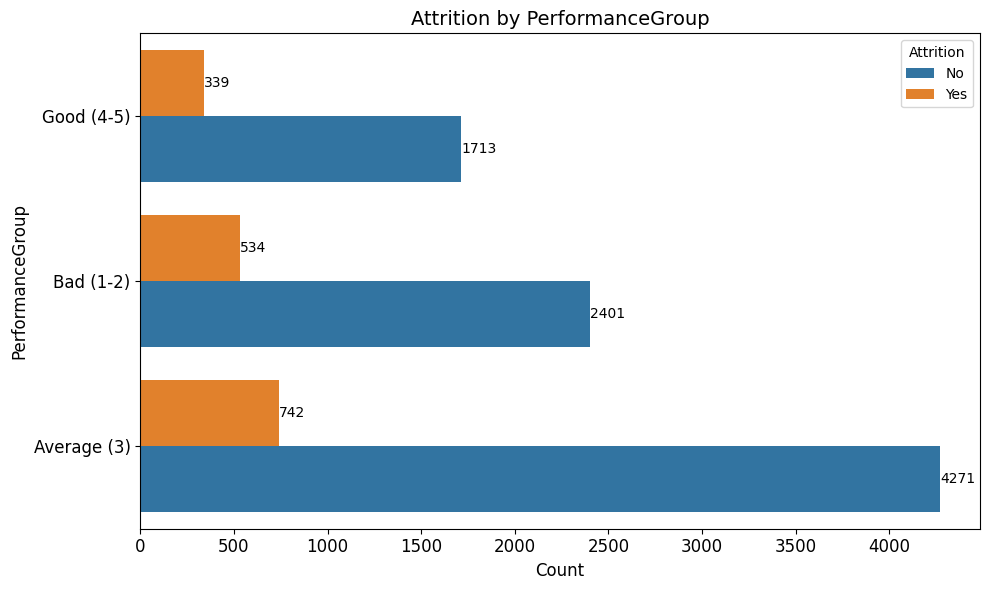

In [313]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attrition_by_column(df, column):
    plt.figure(figsize=(10, 6))

    ax = sns.countplot(
        data=df,
        y=column,
        hue="Attrition",
        order=df[column].value_counts().index  # sorted
    )

    # Add labels on bars
    for container in ax.containers:
        ax.bar_label(container)

    # Reverse the order (upside down)
    ax.invert_yaxis()

    plt.title(f"Attrition by {column}", fontsize=14)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(column, fontsize=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot attrition by Department
plot_attrition_by_column(df, "Department")  

# Plot attrition by JobRole
plot_attrition_by_column(df, "JobRole")

# Plot attrition by Tenure
plot_attrition_by_column(df, "TenureGroup")

# Plot attrition by Performance Rating
plot_attrition_by_column(df, "PerformanceGroup")


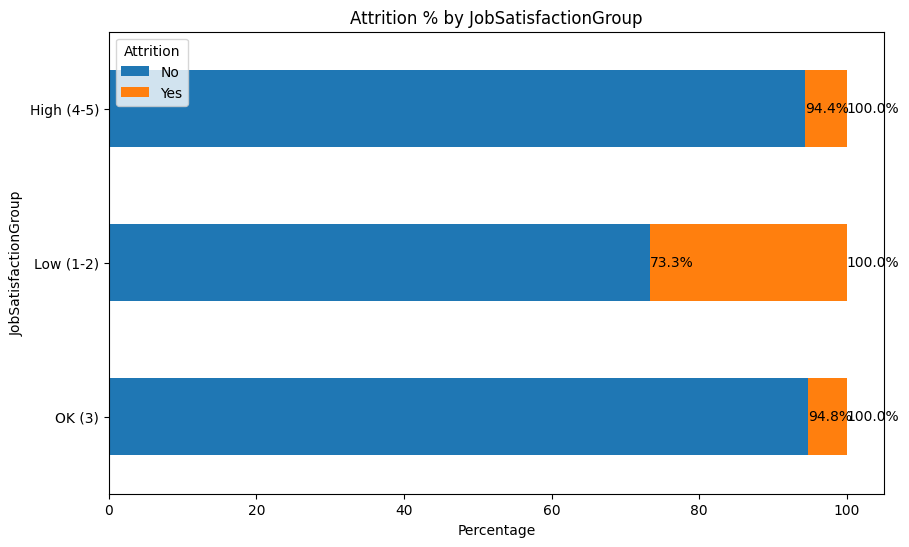

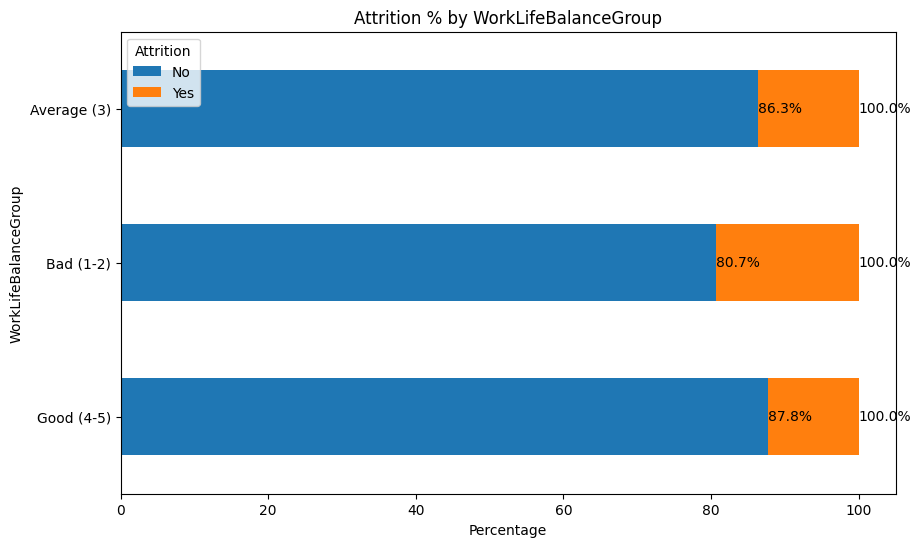

In [314]:
def plot_percentage_stacked(df, column):
    percent_df = (
        df.groupby([column, "Attrition"])
        .size()
        .groupby(level=0)
        .apply(lambda x: 100 * x / x.sum())
        .unstack()
        .fillna(0)
    )
    
    ax= percent_df.plot(
        kind="barh",
        stacked=True,
        figsize=(10, 6)
    )

    uniquelabel = []
    for label in ax.get_yticklabels():
        new_label = label.get_text().split(',')[0]
        new_label = new_label.replace("(", "",1)
        uniquelabel.append(new_label) 

    
    ax.set_title(f"Attrition % by {column}")
    ax.set_xlabel("Percentage")
    ax.set_ylabel(column)
    ax.set_yticklabels(uniquelabel)

    #Add percentage labels
    for i, bars in enumerate(plt.gca().containers):
        plt.gca().bar_label(bars, fmt="%.1f%%")

    plt.gca().invert_yaxis()  # upside down
    plt.show()

# Examples:
plot_percentage_stacked(df, "JobSatisfactionGroup")
plot_percentage_stacked(df, "WorkLifeBalanceGroup")
